==== Fourier coefficient V_G (magnitude) ====
Cosine analytic (eV):           5.000000e-02 eV
Cosine numeric (simpson):       5.000000e-02+0.000000e+00j eV (rel diff 0.000e+00)

Square well analytic (eV):      -3.183099e-02 eV
Square well trapz (eV):         -3.183099e-02-2.603041e-18j eV (rel err 8.225e-09)
Square well simpson (eV):       -3.183099e-02-2.603041e-18j eV (rel err 8.178e-17)



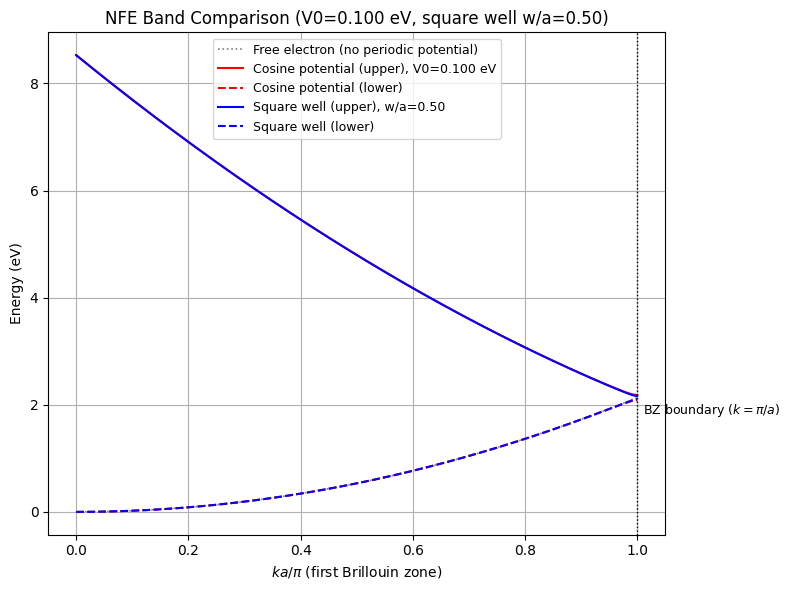


==== Bandgaps at BZ boundary k = π/a ====
Cosine gap (eV):                1.000000e-01 eV (expected ≈ 2|V_G| = 1.000000e-01 eV)
Square well gap (eV):           6.366198e-02 eV (2|V_G| numeric = 6.366198e-02 eV)

[결론] 수치적으로 구한 VG와, 이론상 '밴드갭 ≈ 2|V_G|' 관계가 실험적으로 잘 일치하는지 확인!
[설명] Free electron 밴드는 주기 퍼텐셜이 0일 때의 기준선(이상적 기준)을 제공함 (점선).
[설명] 퍼텐셜 진폭 V0 선택이 NFE model의 성립 조건(E_free ≫ V0)을 만족하도록 구성됨.



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

# ========== 0. Constants & Physical Parameters ==========
a = 4.2e-10           # (m) 격자 상수 (lattice constant)
V0_eV = 0.10          # (eV) 퍼텐셜 깊이/amplitude
w_fraction = 0.5      # (unitless) 우물 폭/격자 상수 비율 (w = a/2)
w = w_fraction * a
hbar = 1.0545718e-34  # (J·s) 플랑크 상수/2π
m = 9.10938356e-31    # (kg) 전자 질량
eV = 1.602176634e-19  # (J) 1전자볼트
V0 = V0_eV * eV       # (J) 내부 계산용 (SI 단위 변환)
G = 2 * np.pi / a     # (1/m) 역격자벡터
G2 = G / 2            # 브릴루앙 존 경계 (k=π/a)

# 에너지 스케일/핀트:
#      "NFE model의 전제: V0 (퍼텐셜 깊이)는 전자의 자유운동 에너지(E_free)보다 훨씬 작아야 근사 유효!"

# ========== 1. 주기 퍼텐셜 함수 정의 ==========
def V_cos(x):
    "코사인 퍼텐셜. V0*cos(2πx/a) 구조."
    return V0 * np.cos(2 * np.pi * x / a)

def V_square_sym_well(x):
    """
    대칭 구형 우물: -V0 깊이, 중심 x=0, 폭 w. 
    나머지 영역은 0. 하나의 주기 [−a/2, a/2]에 대해 정의.
    """
    return np.where(np.abs(x) < w / 2, -V0, 0.0)

# ========== 2. Fourier 계수 V_G 계산 함수 ==========
def VG_numeric(Vfunc, G, Nx=20001, method='simpson'):
    """수치적분법(사다리꼴/심프슨)으로 푸리에 성분 V_G 계산"""
    x = np.linspace(-a / 2, a / 2, Nx)
    integrand = Vfunc(x) * np.exp(-1j * G * x)
    if method == 'trapz':
        val = np.trapz(integrand, x)
    elif method == 'simpson':
        val = simpson(integrand, x)
    else:
        raise ValueError("method must be 'trapz' or 'simpson'")
    return val / a

# ========== 3. Analytic VG (해석적) ==========
VG_cos_analytic = V0 / 2
VG_sq_analytic = - V0 * (1/np.pi) * np.sin(G * w / 2)

# ========== 4. Numeric VG 및 정확성 비교 ==========
VG_sq_trap = VG_numeric(V_square_sym_well, G, method='trapz')
VG_sq_simp = VG_numeric(V_square_sym_well, G, method='simpson')
VG_cos_num = VG_numeric(V_cos, G, method='simpson')

def J_to_eV(x): return (x / eV)

print("==== Fourier coefficient V_G (magnitude) ====")
print(f"Cosine analytic (eV):           {J_to_eV(VG_cos_analytic):.6e} eV")
print(f"Cosine numeric (simpson):       {J_to_eV(VG_cos_num):.6e} eV (rel diff {abs((VG_cos_num-VG_cos_analytic)/VG_cos_analytic):.3e})\n")
print(f"Square well analytic (eV):      {J_to_eV(VG_sq_analytic):.6e} eV")
print(f"Square well trapz (eV):         {J_to_eV(VG_sq_trap):.6e} eV (rel err {abs((VG_sq_trap-VG_sq_analytic)/VG_sq_analytic):.3e})")
print(f"Square well simpson (eV):       {J_to_eV(VG_sq_simp):.6e} eV (rel err {abs((VG_sq_simp-VG_sq_analytic)/VG_sq_analytic):.3e})\n")
# 심프슨 공식이 trapz 대비 높은 정확도! (수치해석적 중요성 어필)

### 밴드구조 계산에 사용할 실제 VG 값 선택 (cos: 해석/구형: 수치-심프슨)
VG_cos = VG_cos_analytic
VG_sq = VG_sq_simp

# ========== 5. 2x2 NFE 밴드구조 공식 ==========
def E_free_J(k):
    return (hbar ** 2 * k ** 2) / (2 * m)
k_vals = np.linspace(0, G2, 800)
Efree_eV = J_to_eV(E_free_J(k_vals))

E_cos_bands = np.zeros((len(k_vals), 2))
E_sq_bands = np.zeros((len(k_vals), 2))
for i, k in enumerate(k_vals):
    Ek = E_free_J(k)
    EkG = E_free_J(k - G)
    H_cos = np.array([[Ek, VG_cos], [np.conj(VG_cos), EkG]], dtype=complex)
    E_cos_bands[i, :] = J_to_eV(np.linalg.eigvalsh(H_cos))
    H_sq = np.array([[Ek, VG_sq], [np.conj(VG_sq), EkG]], dtype=complex)
    E_sq_bands[i, :] = J_to_eV(np.linalg.eigvalsh(H_sq))

# ========== 6. 시각화: 일관성 있는 레이블 & 선 ==========
plt.figure(figsize=(8, 6))
x_norm = k_vals * a / np.pi
plt.plot(x_norm, Efree_eV, color='0.5', linestyle=':', linewidth=1.2, label='Free electron (no periodic potential)', zorder=1)
plt.plot(x_norm, E_cos_bands[:, 1], 'r', linestyle='-', label=f'Cosine potential (upper), V0={V0_eV:.3f} eV', zorder=2)
plt.plot(x_norm, E_cos_bands[:, 0], 'r', linestyle='--', label='Cosine potential (lower)', zorder=2)
plt.plot(x_norm, E_sq_bands[:, 1], 'b', linestyle='-', label=f'Square well (upper), w/a={w_fraction:.2f}', zorder=3)
plt.plot(x_norm, E_sq_bands[:, 0], 'b', linestyle='--', label='Square well (lower)', zorder=3)
plt.axvline(x=1.0, color='k', linestyle=':', linewidth=1.0)
plt.text(1.01, max(Efree_eV)*0.96, r'BZ boundary $(k=\pi/a)$', va='top', fontsize=9)
plt.xlabel(r'$ka/\pi$ (first Brillouin zone)')
plt.ylabel('Energy (eV)')
plt.title(f'NFE Band Comparison (V0={V0_eV:.3f} eV, square well w/a={w_fraction:.2f})')
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== 7. 밴드갭/밴드정량, 이론 비교 ===================
idx_bz = np.argmin(np.abs(k_vals - G2))
gap_cos = E_cos_bands[idx_bz, 1] - E_cos_bands[idx_bz, 0]
gap_sq = E_sq_bands[idx_bz, 1] - E_sq_bands[idx_bz, 0]
print("\n==== Bandgaps at BZ boundary k = π/a ====")
print(f"Cosine gap (eV):                {gap_cos:.6e} eV (expected ≈ 2|V_G| = {2*J_to_eV(abs(VG_cos)):.6e} eV)")
print(f"Square well gap (eV):           {gap_sq:.6e} eV (2|V_G| numeric = {2*J_to_eV(abs(VG_sq)):.6e} eV)")
print("\n[결론] 수치적으로 구한 VG와, 이론상 '밴드갭 ≈ 2|V_G|' 관계가 실험적으로 잘 일치하는지 확인!")
print("[설명] Free electron 밴드는 주기 퍼텐셜이 0일 때의 기준선(이상적 기준)을 제공함 (점선).")
print("[설명] 퍼텐셜 진폭 V0 선택이 NFE model의 성립 조건(E_free ≫ V0)을 만족하도록 구성됨.\n")

